# Autism Disorder Screening - Children #

## Found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Autistic+Spectrum+Disorder+Screening+Data+for+Children++)

- **Source**: *Fadi Fayez Thabtah*
<br>
    Department of Digital Technology
<br>
    Manukau Institute of Technology
<br>
    Auckland, New Zealand

In [109]:
import io
import os
"""import zipfile
from zipfile import ZipFile
from urllib.request import urlretrieve
"""

from autism_data.arff_read import arff_to_df
from autism_data.arff_read import df_get_uniform_dummies

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import os
plt.style.use('seaborn-notebook')

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

np.set_printoptions(suppress=True)

### Read in the data from UCI website and extract .arff file from zip folder

In [110]:
df = arff_to_df()

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 19 columns):
A1_Score           292 non-null category
A2_Score           292 non-null category
A3_Score           292 non-null category
A4_Score           292 non-null category
A5_Score           292 non-null category
A6_Score           292 non-null category
A7_Score           292 non-null category
A8_Score           292 non-null category
A9_Score           292 non-null category
A10_Score          292 non-null category
age                292 non-null float64
gender             292 non-null category
ethnicity          292 non-null category
jaundice           292 non-null int64
autism             292 non-null int64
used_app_before    292 non-null int64
result             292 non-null float64
relation           292 non-null category
Class/ASD          292 non-null int64
dtypes: category(13), float64(2), int64(4)
memory usage: 19.1 KB


### Converting the data and description objects to Pandas DataFrame

- Need to decode the string from utf-8 format to convert to pandas object

In [5]:
df.ethnicity.value_counts()

White-European    108
Asian              46
Unknown            43
Middle_Eastern     27
South_Asian        21
Others             14
Black              14
Latino              8
Hispanic            7
Turkish             2
Pasifika            2
Name: ethnicity, dtype: int64

In [6]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,used_app_before,result,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,6.0,m,Others,0,0,0,5.0,Family Member,0
1,1,1,0,0,1,1,0,1,0,0,6.0,m,Middle_Eastern,0,0,0,5.0,Family Member,0
2,1,1,0,0,0,1,1,1,0,0,6.0,m,Unknown,0,0,1,5.0,Unknown,0
3,0,1,0,0,1,1,0,0,0,1,5.0,f,Unknown,1,0,0,4.0,Unknown,0
4,1,1,1,1,1,1,1,1,1,1,5.0,m,Others,1,0,0,10.0,Family Member,1


In [7]:
for column in list(df.columns):
    print(column,": ",df[column].nunique())

A1_Score :  2
A2_Score :  2
A3_Score :  2
A4_Score :  2
A5_Score :  2
A6_Score :  2
A7_Score :  2
A8_Score :  2
A9_Score :  2
A10_Score :  2
age :  8
gender :  2
ethnicity :  11
jaundice :  2
autism :  2
used_app_before :  2
result :  11
relation :  4
Class/ASD :  2


In [8]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'autism', 'used_app_before', 'result',
       'relation', 'Class/ASD'],
      dtype='object')

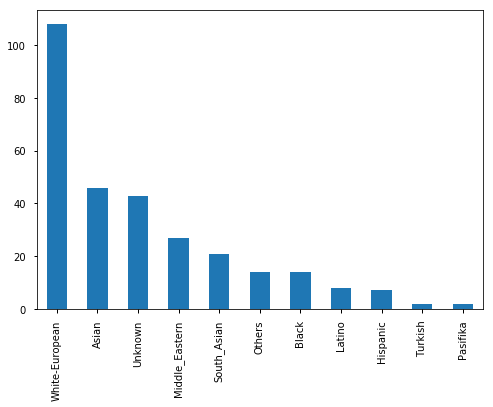

In [9]:
df.ethnicity.value_counts().plot(kind='bar')
plt.show()

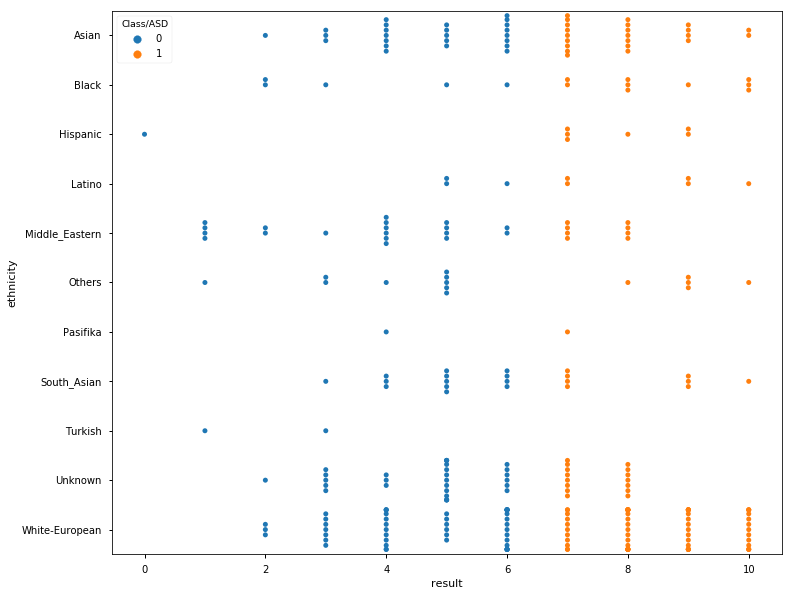

In [10]:
plt.figure(figsize=(12,10))
sb.swarmplot(x='result',y='ethnicity',data=df,hue='Class/ASD')
plt.show()

In [11]:
df.result.value_counts()

8.0     44
7.0     44
5.0     41
6.0     40
4.0     33
9.0     32
3.0     21
10.0    21
2.0      9
1.0      6
0.0      1
Name: result, dtype: int64

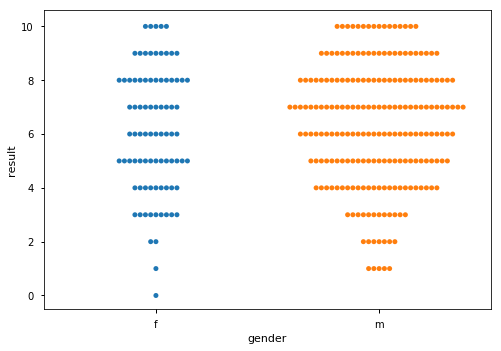

In [12]:
sb.swarmplot(x='gender',y='result',data=df)
plt.show()

### Exploring the data, some conclusions:
    - Scoring 7 or higher is associated with Autism diagnosis
    - No obvious distinction between the genders, other than males making up a large proportion of the sample
    - Some interesting differences between ethnicities, but not clear if that is meaningful

In [13]:
df.relation.unique()

[Family Member, Unknown, Self, Health care professional]
Categories (4, object): [Family Member, Unknown, Self, Health care professional]

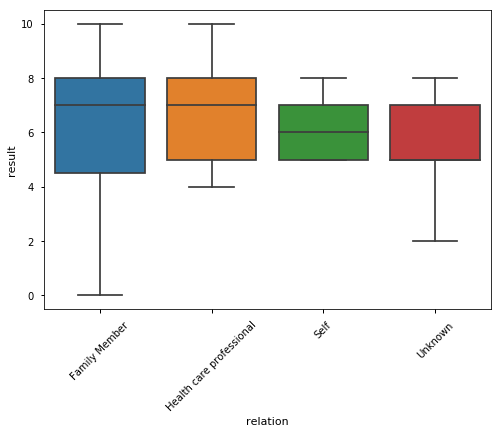

In [14]:
sb.boxplot(x='relation',y='result',data=df)
plt.xticks(rotation=45)
plt.show()

In [15]:
df = df.drop('result',axis=1)

In [16]:
binary_df = df_get_uniform_dummies(df)
binary_df = binary_df.iloc[:,10:]
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 19 columns):
age                             292 non-null int64
jaundice                        292 non-null int64
autism                          292 non-null int64
used_app_before                 292 non-null int64
Class/ASD                       292 non-null int64
gen_m                           292 non-null int64
eth_Black                       292 non-null int64
eth_Hispanic                    292 non-null int64
eth_Latino                      292 non-null int64
eth_Middle_Eastern              292 non-null int64
eth_Others                      292 non-null int64
eth_Pasifika                    292 non-null int64
eth_South_Asian                 292 non-null int64
eth_Turkish                     292 non-null int64
eth_Unknown                     292 non-null int64
eth_White-European              292 non-null int64
rel_Health care professional    292 non-null int64
rel_Self                    

** Now we are ready for machine learning! **

In [17]:
def log_loss(predictions,actual,eps=1e-15):
    '''take an array of prediction probabilities (clipped to avoid undefined values) and measures accuracy while
    also factoring for confidence'''
    assert (max(predictions)<=1 and min(predictions)>=0), 'Please make sure to use predict_proba'
    
    preds_clipped = np.clip(predictions,eps,1-eps)
    
    loss = -1 * np.mean((actual * np.log(preds_clipped)) + ((1-actual) * np.log(1-preds_clipped)))
    
    return loss

In [18]:
log_loss(np.array([.5,.85,.25]),np.array([1,1,0]))

0.38111606083650035

In [19]:
bern = BernoulliNB()

In [20]:
binary_features = binary_df.drop('Class/ASD',axis=1)
binary_features.head()

,age,jaundice,autism,used_app_before,gen_m,eth_Black,eth_Hispanic,eth_Latino,eth_Middle_Eastern,eth_Others,eth_Pasifika,eth_South_Asian,eth_Turkish,eth_Unknown,eth_White-European,rel_Health care professional,rel_Self,rel_Unknown
0,6,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,6,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,6,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,5,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,5,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(binary_features.values,binary_df['Class/ASD'].values,random_state=12)

In [22]:
bern.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [23]:
bern_y_pred = bern.predict(X_test)
bern_y_pred_proba = bern.predict_proba(X_test)
print(len(bern_y_pred[bern_y_pred == y_test])/len(y_test))

0.6438356164383562


In [24]:
bern_y_pred

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1], dtype=int64)

In [25]:
precision_score(bern_y_pred,y_test)

0.7142857142857143

In [26]:
accuracy_score(bern_y_pred,y_test)

0.64383561643835618

In [27]:
log_loss(bern_y_pred_proba[:,1],y_test)

0.65215790639947413

In [28]:
for b in binary_features.columns:
    print('{}: {}'.format(b,binary_features[b].sum()))

age: 1854
jaundice: 80
autism: 49
used_app_before: 11
gen_m: 208
eth_Black: 14
eth_Hispanic: 7
eth_Latino: 8
eth_Middle_Eastern: 27
eth_Others: 14
eth_Pasifika: 2
eth_South_Asian: 21
eth_Turkish: 2
eth_Unknown: 43
eth_White-European: 108
rel_Health care professional: 13
rel_Self: 5
rel_Unknown: 43


In [29]:
logreg = LogisticRegression()

In [30]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
y_logreg_pred = logreg.predict(X_test)

In [32]:
y_logreg_pred

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0], dtype=int64)

In [33]:
accuracy_score(y_logreg_pred,y_test)

0.60273972602739723

In [34]:
precision_score(y_logreg_pred,y_test)

0.54285714285714282

In [35]:
y_logreg_pred_proba = logreg.predict_proba(X_test)

In [36]:
log_loss(y_logreg_pred_proba[:,1],y_test)

0.66041792951822209

In [37]:
features_all = binary_df.drop(['Class/ASD'],axis=1)
target = binary_df.loc[:,['Class/ASD']]

In [38]:
features_all.head()

,age,jaundice,autism,used_app_before,gen_m,eth_Black,eth_Hispanic,eth_Latino,eth_Middle_Eastern,eth_Others,eth_Pasifika,eth_South_Asian,eth_Turkish,eth_Unknown,eth_White-European,rel_Health care professional,rel_Self,rel_Unknown
0,6,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,6,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,6,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,5,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,5,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [39]:
fp,tp, thresholds = roc_curve(y_test,y_logreg_pred_proba[:,1])

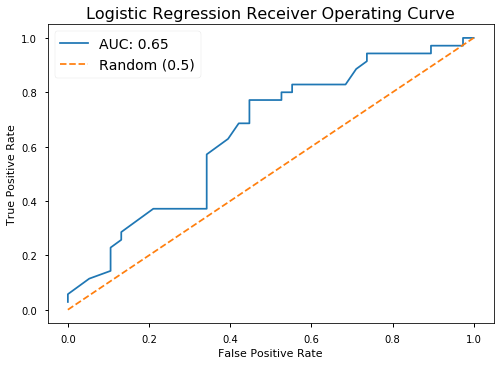

In [40]:
AUC = round(roc_auc_score(y_test,y_logreg_pred_proba[0:,1]),2)

ax = plt.plot(fp,tp,label="AUC: {}".format(AUC))
ax = plt.plot([0,1],[0,1],linestyle='--',label='Random (0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0,fontsize=14)
plt.title('Logistic Regression Receiver Operating Curve',fontsize=16)
plt.show()

In [41]:
roc_auc_score(y_test,y_logreg_pred_proba[0:,1])

0.64849624060150368

### Conclusion: simple models (Bernoulli and Logistic Regression) may not cut it
     Need to try cross validation before moving to more complex models

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
neighbors = np.arange(1,10)

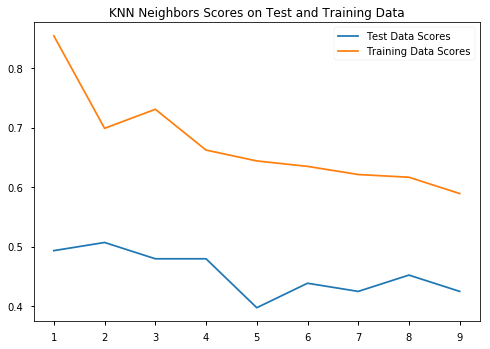

In [44]:
test_scores = np.empty(len(neighbors))
train_scores = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    test_scores[i] = knn.score(X_test,y_test)
    train_scores[i] = knn.score(X_train,y_train)
    
plt.plot(neighbors,test_scores,label='Test Data Scores')
plt.plot(neighbors,train_scores,label='Training Data Scores')
plt.title('KNN Neighbors Scores on Test and Training Data')
plt.legend(loc=0)
plt.show()

In [45]:
knn_y_pred = knn.predict(X_test)

In [46]:
knn.score(X_train,y_train)

0.58904109589041098

In [47]:
knn.score(X_test,y_test)

0.42465753424657532

In [48]:
from sklearn.svm import SVC

In [49]:
svc = SVC()

In [50]:
svc.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
svc.score(X_train,y_train)

0.56621004566210043

In [52]:
svc.score(X_test,y_test)

0.53424657534246578

In [53]:
svc_y_pred = svc.predict(X_test)

In [54]:
svc.decision_function(X_train).shape

(219,)

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
tree = DecisionTreeClassifier(min_samples_leaf=4)

In [57]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [58]:
tree_y_pred = tree.predict(X_test)
tree_y_pred_proba = tree.predict_proba(X_test)

In [59]:
tree.score(X_test,y_test)

0.47945205479452052

In [60]:
fp_t,tp_t, thresholds = roc_curve(y_test,tree_y_pred_proba[:,1])

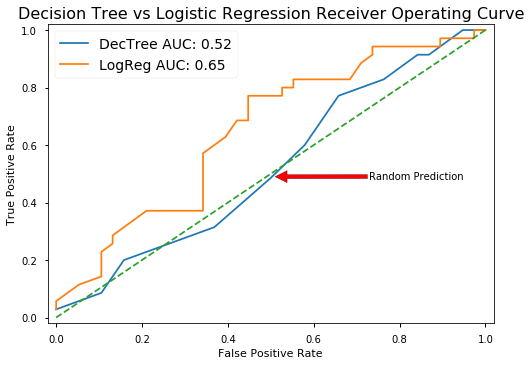

In [61]:
t_AUC = round(roc_auc_score(y_test,tree_y_pred_proba[0:,1]),2)
log_AUC = round(roc_auc_score(y_test,y_logreg_pred_proba[0:,1]),2)

ax = plt.plot(fp_t,tp_t,label="DecTree AUC: {}".format(t_AUC))
ax = plt.plot(fp,tp,label="LogReg AUC: {}".format(log_AUC))
ax = plt.plot([0,1],[0,1],linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0,fontsize=14)
plt.title('Decision Tree vs Logistic Regression Receiver Operating Curve',fontsize=16)
plt.margins(0.02)
plt.annotate("Random Prediction",xy=(.51,.49),xytext=(.73,.48),arrowprops={'facecolor':'red'})
plt.show()

### So far, Logistic Regression provides the most accurate model

In [62]:
mat = np.array([[3,2,5],[6,1,4]])

In [63]:
mat

array([[3, 2, 5],
       [6, 1, 4]])

In [64]:
mat.T

array([[3, 6],
       [2, 1],
       [5, 4]])

In [65]:
mat2 = np.array([[2,4],[1,3],[0,0],[0,0]])

In [66]:
mat2

array([[2, 4],
       [1, 3],
       [0, 0],
       [0, 0]])

In [67]:
mat2.T

array([[2, 1, 0, 0],
       [4, 3, 0, 0]])

In [68]:
prod = mat2 @ mat2.T

In [69]:
prod.diagonal()

array([20, 10,  0,  0])

In [70]:
np.linalg.eig(prod)

(array([ 29.86606875,   0.13393125,   0.        ,   0.        ]),
 array([[ 0.81741556, -0.57604844,  0.        ,  0.        ],
        [ 0.57604844,  0.81741556,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [71]:
w, v = np.linalg.eig(prod)

In [72]:
vec = np.sqrt(w)

In [73]:
eigen_vec = np.diag(vec)[:mat2.shape[0],:mat2.shape[1]]

In [74]:
def singular_value_decomposition(matrix):
    w, v = np.linalg.eig(matrix @ matrix.T)
    svd = np.diag(np.sqrt(w))[:matrix.shape[1],:matrix.shape[1]]
    return svd

In [75]:
singular_value_decomposition(mat2)

array([[ 5.4649857 ,  0.        ],
       [ 0.        ,  0.36596619]])

### Trying out Neural Network Analysis to Improve Predictions

In [76]:
all_features = binary_df.drop('Class/ASD',axis=1)

In [98]:
feature_matrix = all_features.as_matrix()

feature_columns = feature_matrix.shape[1]

target_split = to_categorical(target)

In [99]:
nnX_train, nnX_test, nny_train, nny_test = train_test_split(feature_matrix,target_split,random_state=12,stratify=target_split)

In [100]:
model = Sequential()

In [101]:
model.add(Dense(100,activation='relu',input_shape=(feature_columns,)))

In [102]:
model.add(Dense(2,activation='softmax'))

In [103]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [104]:
model.fit(nnX_train,nny_train,batch_size=50,epochs=20)

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.7176 - acc: 0.4612
Epoch 2/20
219/219 [==============================] - 0s 55us/step - loss: 0.6913 - acc: 0.5251
Epoch 3/20
219/219 [==============================] - 0s 55us/step - loss: 0.6844 - acc: 0.5662
Epoch 4/20
219/219 [==============================] - 0s 37us/step - loss: 0.6800 - acc: 0.5479
Epoch 5/20
219/219 [==============================] - 0s 55us/step - loss: 0.6766 - acc: 0.5388
Epoch 6/20
219/219 [==============================] - 0s 55us/step - loss: 0.6707 - acc: 0.5616
Epoch 7/20
219/219 [==============================] - 0s 37us/step - loss: 0.6676 - acc: 0.6073
Epoch 8/20
219/219 [==============================] - 0s 37us/step - loss: 0.6698 - acc: 0.5845
Epoch 9/20
219/219 [==============================] - 0s 37us/step - loss: 0.6611 - acc: 0.5845
Epoch 10/20
219/219 [==============================] - 0s 55us/step - loss: 0.6608 - acc: 0.6119
Epoch 11/20
219/219 [===================

In [105]:
positive_preds = model.predict(nnX_test)

In [106]:
log_loss(positive_preds[:,1],nny_test[:,1])

0.72253608356599941

In [107]:
nn_fpr, nn_tpr, nn_thresh = roc_curve(nny_test[:,1],positive_preds[:,1])

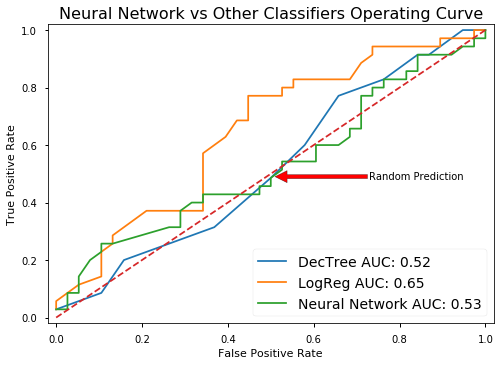

In [108]:
t_AUC = round(roc_auc_score(y_test,tree_y_pred_proba[0:,1]),2)
log_AUC = round(roc_auc_score(y_test,y_logreg_pred_proba[0:,1]),2)
nn_AUC = round(roc_auc_score(nny_test[:,1],positive_preds[:,1]),2)

ax = plt.plot(fp_t,tp_t,label="DecTree AUC: {}".format(t_AUC))
ax = plt.plot(fp,tp,label="LogReg AUC: {}".format(log_AUC))
ax = plt.plot(nn_fpr,nn_tpr,label="Neural Network AUC: {}".format(nn_AUC))
ax = plt.plot([0,1],[0,1],linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0,fontsize=14)
plt.title('Neural Network vs Other Classifiers Operating Curve',fontsize=16)
plt.margins(0.02)
plt.annotate("Random Prediction",xy=(.51,.49),xytext=(.73,.48),arrowprops={'facecolor':'red'})
plt.show()

### Neural Network performance plummets without the redundant Question features